In [96]:
import pandas as pd
import biblib.bib
import re
import graphviz
import os
import sys
import math
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import pygraphviz
import matplotlib.pyplot as plt
from semanticscholar import SemanticScholar
from unidecode import unidecode
from alphabet_detector import AlphabetDetector
import seaborn as sns

In [3]:
def build_cite_key(authors, year, title):
    invalid = '<>:"/\|?*{}()\''

    authors = re.sub(r'\\. ', '', authors)
    authors = re.sub(r'\\.', '', authors)
    authors = authors.replace('.', '')
    authors = unidecode(authors)

    authors = authors.replace('-', ' ')
    authors = authors.replace('–', ' ')
    authors = authors.replace('‐', ' ')
    authors = authors.replace('’', ' ')
    authors = authors.replace(' *', '')
    for char in invalid: authors = authors.replace(char, '')

    title_invalid = '!.,$&#`+;’‐–‘^'
    title_proc = title.lower().replace(' ', '_')
    title_proc = title_proc.replace('~','_')
    title_proc = title_proc.replace('ı', 'i')
    title_proc = title_proc.replace('ó', 'o')
    title_proc = title_proc.replace('é', 'e')
    for char in invalid: title_proc = title_proc.replace(char, '')
    for char in title_invalid: title_proc = title_proc.replace(char, '')
    title_proc = title_proc.replace('&amp;', '')
    title_proc = title_proc.replace('amp;', '')

    def_authors_regex = re.compile(r'^[a-z]+( [a-z]+)*,')
    def_authors_match = re.match(def_authors_regex, authors.lower())

    if(('and' not in authors) and (',' not in authors)): # SINGLE AUTHOR
        author_proc = authors.split().pop(-1).lower()
        cite_key = f"{author_proc}_{year}_{title_proc}"
    elif(bool(def_authors_match)): # SURNAME(S), NAME(S)
        author_proc = def_authors_match[0].replace(',','').replace(' ', '_')
        cite_key = f"{author_proc}_{year}_{title_proc}"
    else: # NAME(S) SURNAME(S) AND ...
        ns_authors_regex = re.compile(r'[a-z]+ \band\b')
        author_proc = ns_authors_regex.search(authors.lower()).group().replace(' and', '')
        cite_key = f"{author_proc}_{year}_{title_proc}"
    
    cite_key = cite_key.replace('-', '_')
    for char in invalid: cite_key = cite_key.replace(char, '')
    
    return cite_key

In [4]:
venues = {
    'Conferences': ['ACL','CIKM','COLING','EACL','ECIR','ECML PKDD','EMNLP','KDD','NAACL','SIGIR'],
    'Journals': ['Decision Support Systems', 'Expert Systems with Applications', 'Information Sciences', 'Journal of Infometrics', 'Knowledge-Based Systems', 'Pattern Recognition']
}

init_selection = [
    'card_2018_neural_models_for_documents_with_metadata',
    'lau_2017_topically_driven_neural_language_model',
    'wu_2020_neural_mixed_counting_models_for_dispersed_topic_discovery',
    'maiti_2019_spatial_aggregation_facilitates_discovery_of_spatial_topics',
    'huang_2018_phrasectm_correlated_topic_modeling_on_phrases_within_markov_random_fields',
    'ahmadvand_2019_concet_entity_aware_topic_classification_for_open_domain_conversational_agents',
    'hosseiny_marani_2022_one_rating_to_rule_them_all_evidence_of_multidimensionality_in_human_assessment_of_topic_labeling_quality',
    'nouri_2020_mining_crowdsourcing_problems_from_discussion_forums_of_workers',
    'yin_2022_improving_deep_embedded_clustering_via_learning_cluster_level_representations',
    'an_2018_model_free_context_aware_word_composition',
    'austin_2022_community_topic_topic_model_inference_by_consecutive_word_community_discovery',
    'sorodoc_2017_multimodal_topic_labelling',
    'zhao_2021_adversarial_learning_of_poisson_factorisation_model_for_gauging_brand_sentiment_in_user_reviews',
    'popa_2021_bart_tl_weakly_supervised_topic_label_generation',
    'aletras_2017_labeling_topics_with_images_using_a_neural_network',
    'zosa_2022_multilingual_topic_labelling_of_news_topics_using_ontological_mapping',
    'ferner_2020_a_semi_discriminative_approach_for_sub_sentence_level_topic_classification_on_a_small_dataset',
    'barbieri_2017_survival_factorization_on_diffusion_networks',
    'hu_2020_neural_topic_modeling_with_cycle_consistent_adversarial_training',
    'yang_2017_adapting_topic_models_using_lexical_associations_with_tree_priors',
    'wang_2021_phrase_bert_improved_phrase_embeddings_from_bert_with_an_application_to_corpus_exploration',
    'zhou_2020_condolence_and_empathy_in_online_communities',
    'zhang_2018_taxogen_unsupervised_topic_taxonomy_construction_by_adaptive_term_embedding_and_clustering',
    'huang_2020_corel_seed_guided_topical_taxonomy_construction_by_concept_learning_and_relation_transferring',
    'meng_2020_hierarchical_topic_mining_via_joint_spherical_tree_and_text_embedding',
    'song_2022_automatic_phenotyping_by_a_seed_guided_topic_model',
    'pergola_2021_a_disentangled_adversarial_neural_topic_model_for_separating_opinions_from_plots_in_user_reviews',
    'doogan_2021_topic_model_or_topic_twaddle_re_evaluating_semantic_interpretability_measures',
    'mukherjee_2020_read_what_you_need_controllable_aspect_based_opinion_summarization_of_tourist_reviews',
    'chin_2017_totem_personal_tweets_summarization_on_mobile_devices',
    'alokaili_2020_automatic_generation_of_topic_labels',
    'xu_2020_how_do_consumers_in_the_sharing_economy_value_sharing_evidence_from_online_reviews',
    'ibrahim_2019_a_text_analytics_approach_for_online_retailing_service_improvement_evidence_from_twitter',
    'goldberg_2022_sourcing_product_innovation_intelligence_from_online_reviews',
    'roeder_2022_data_driven_decision_making_in_credit_risk_management_the_information_value_of_analyst_reports',
    'altinel_2022_social_media_analysis_by_innovative_hybrid_algorithms_with_label_propagation',
    'sakshi_2023_recent_trends_in_mathematical_expressions_recognition_an_lda_based_analysis',
    'gregoriades_2021_supporting_digital_content_marketing_and_messaging_through_topic_modelling_and_decision_trees',
    'pablos_2018_w2vlda_almost_unsupervised_system_for_aspect_based_sentiment_analysis',
    'korfiatis_2019_measuring_service_quality_from_unstructured_data_a_topic_modeling_application_on_airline_passengers_online_reviews',
    'gomez_2022_large_scale_analysis_of_open_mooc_reviews_to_support_learners_course_selection',
    'fang_2021_criteria_determination_of_analytic_hierarchy_process_using_a_topic_model',
    'lebena_2022_preliminary_exploration_of_topic_modelling_representations_for_electronic_health_records_coding_according_to_the_international_classification_of_diseases_in_spanish',
    'effrosynidis_2022_the_climate_change_twitter_dataset',
    'korencic_2018_document_based_topic_coherence_measures_for_news_media_text',
    'bastani_2019_latent_dirichlet_allocation_lda_for_topic_modeling_of_the_cfpb_consumer_complaints',
    'wahid_2022_topic2labels_a_framework_to_annotate_and_classify_the_social_media_data_through_lda_topics_and_deep_learning_models_for_crisis_response',
    'kim_2020_word2vec_based_latent_semantic_analysis_w2v_lsa_for_topic_modeling_a_study_on_blockchain_technology_trend_analysis',
    'campos_2022_providing_recommendations_for_communities_of_learners_in_moocs_ecosystems',
    'zhou_2022_a_weakly_supervised_graph_based_joint_sentiment_topic_model_for_multi_topic_sentiment_analysis',
    'yang_2021_author_topic_model_for_co_occurring_normal_documents_and_short_texts_to_explore_individual_user_preferences',
    'liu_2018_identifying_impact_of_intrinsic_factors_on_topic_preferences_in_online_social_media_a_nonparametric_hierarchical_bayesian_approach',
    'zhang_2018_does_deep_learning_help_topic_extraction_a_kernel_k_means_clustering_method_with_word_embedding',
    'kim_2022_developing_a_topic_driven_method_for_interdisciplinarity_analysis',
    'ebadi_2020_application_of_machine_learning_techniques_to_assess_the_trends_and_alignment_of_the_funded_research_output',
    'kim_2022_exploring_scientific_trajectories_of_a_large_scale_dataset_using_topic_integrated_path_extraction',
    'cassi_2017_improving_fitness_mapping_research_priorities_against_societal_needs_on_obesity',
    'xu_2020_topic_linked_innovation_paths_in_science_and_technology',
    'amon_2022_is_it_all_bafflegab____linguistic_and_meta_characteristics_of_research_articles_in_prestigious_economics_journals',
    'chen_2020_a_topic_sensitive_trust_evaluation_approach_for_users_in_online_communities',
    'alp_2019_influence_factorization_for_identifying_authorities_in_twitter',
    'alp_2018_identifying_topical_influencers_on_twitter_based_on_user_behavior_and_network_topology',
    'zhang_2017_detecting_and_predicting_the_topic_change_of_knowledge_based_systems_a_topic_based_bibliometric_analysis_from_1991_to_2016',
    'chen_2019_experimental_explorations_on_short_text_topic_mining_between_lda_and_nmf_based_schemes',
    'zhang_2019_learning_document_representation_via_topic_enhanced_lstm_model'
]

bs_selection = [
    'xiang_2017_a_comparative_analysis_of_major_online_review_platforms_implications_for_social_media_analytics_in_hospitality_and_tourism',
    'liu_2017_an_investigation_of_brand_related_user_generated_content_on_twitter',
    'kim_2019_an_ontology_based_labeling_of_influential_topics_using_topic_network_analysis',
    'huang_2018_analyst_information_discovery_and_interpretation_roles_a_topic_modeling_approach',
    'maier_2018_applying_lda_topic_modeling_in_communication_research_toward_a_valid_and_reliable_methodology',
    'karami_2018_characterizing_diabetes_diet_exercise_and_obesity_comments_on_twitter',
    'aletras_2017_evaluating_topic_representations_for_exploring_document_collections',
    'smith_2017_evaluating_visual_representations_for_topic_understanding_and_their_effects_on_manually_generated_topic_labels',
    'savin_2021_free_associations_of_citizens_and_scientists_with_economic_and_green_growth_a_computational_linguistics_analysis',
    'syed_2017_full_text_or_abstract_examining_topic_coherence_scores_using_latent_dirichlet_allocation',
    'li_2020_global_surveillance_of_covid_19_by_mining_news_media_using_a_multi_source_dynamic_embedded_topic_model',
    'alp_2018_identifying_topical_influencers_on_twitter_based_on_user_behavior_and_network_topology',
    'morstatter_2017_in_search_of_coherence_and_consensus_measuring_the_interpretability_of_statistical_topics',
    'light_2017_managing_the_boundaries_of_taste_culture_valuation_and_computational_social_science',
    'clare_2019_modelling_research_topic_trends_in_community_forestry',
    'nerghes_2019_narratives_of_the_refugee_crisis_a_comparative_study_of_mainstream_media_and_twitter',
    'campos_2020_recommendation_system_for_knowledge_acquisition_in_moocs_ecosystems',
    'zhang_2017_scientific_evolutionary_pathways_identifying_and_visualizing_relationships_for_scientific_topics',
    'bagozzi_2018_the_politics_of_scrutiny_in_human_rights_monitoring_evidence_from_structural_topic_models_of_us_state_department_human_rights_reports',
    'dahal_2019_topic_modeling_and_sentiment_analysis_of_global_climate_change_tweets',
    'grajzl_2019_toward_understanding_17th_century_english_culture_a_structural_topic_model_of_francis_bacontextquotesingles_ideas',
    'hoang_2019_towards_autoencoding_variational_inference_for_aspect_based_opinion_summary',
    'herzog_2018_transfer_topic_labeling_with_domain_specific_knowledge_base_an_analysis_of_uk_house_of_commons_speeches_1935_2014',
    'karami_2019_twitter_speaks_a_case_of_national_disaster_situational_awareness',
    'gourru_2018_united_we_stand_using_multiple_strategies_for_topic_labeling',
    'kuhn_2018_using_structural_topic_modeling_to_identify_latent_topics_and_trends_in_aviation_incident_reports',
    'chen_2020_what_are_moocs_learners_concerns_text_analysis_of_reviews_for_computer_science_courses'
]

fs_selection = [
    'stamolampros_2019_job_satisfaction_and_employee_turnover_determinants_in_high_contact_services_insights_from_employeesonline_reviews',
    'chen_2020_detecting_latent_topics_and_trends_in_educational_technologies_over_four_decades_using_structural_topic_modeling_a_retrospective_of_all_volumes_of_computers__education',
    'stamolampros_2020_harnessing_the_wisdom_of_employees_from_online_reviews',
    'amat_lefort_2022_quality_40_big_data_analytics_to_explore_service_quality_attributes_and_their_relation_to_user_sentiment_in_airbnb_reviews',
    'ding_2020_employing_structural_topic_modelling_to_explore_perceived_service_quality_attributes_in_airbnb_accommodation',
    'yang_2021_revealing_industry_challenge_and_business_response_to_covid_19_a_text_mining_approach',
    'hagen_2019_open_data_visualizations_and_analytics_as_tools_for_policy_making',
    'monselise_2021_topics_and_sentiments_of_public_concerns_regarding_covid_19_vaccines_social_media_trend_analysis',
    'aman_2021_listen_to_e_scooter_riders_mining_rider_satisfaction_factors_from_app_store_reviews',
    'luo_2020_topic_modelling_for_theme_park_online_reviews_analysis_of_disneyland',
    'meena_2022_online_food_delivery_companies_performance_and_consumers_expectations_during_covid_19_an_investigation_using_machine_learning_approach',
    'singh_2022_modeling_the_public_attitude_towards_organic_foods_a_big_data_and_text_mining_approach',
    'wang_2020_a_topic_based_patent_analytics_approach_for_exploring_technological_trends_in_smart_manufacturing',
    'he_2021_automatic_topic_labeling_using_graph_based_pre_trained_neural_embedding',
    'chen_2020_a_structural_topic_modeling_based_bibliometric_study_of_sentiment_analysis_literature',
    'chen_2022_a_decade_of_sentic_computing_topic_modeling_and_bibliometric_analysis',
    'yoo_2023_exploring_the_nexus_between_food_and_vegn_lifestyle_via_text_mining_based_online_community_analytics',
    'chung_2022_understanding_music_streaming_services_via_text_mining_of_online_customer_reviews',
    'jebari_2021_the_use_of_citation_context_to_detect_the_evolution_of_research_topics_a_large_scale_analysis',
    'huang_2022_identification_of_topic_evolution_network_analytics_with_piecewise_linear_representation_and_word_embedding',
    'zhang_2021_topic_evolution_disruption_and_resilience_in_early_covid_19_research',
    'ebadi_2021_understanding_the_temporal_evolution_of_covid_19_research_through_machine_learning_and_natural_language_processing',
    'barrera_barrera_2022_selecting_the_appropriate_leading_journal_in_hospitality_and_tourism_research_a_guide_based_on_the_topic_journal_fit_and_the_jcr_impact_factor',
    'truica_2021_tlatr_automatic_topic_labeling_using_automatic_domain_specific_term_recognition',
    'he_2019_automatic_labeling_of_topic_models_using_graph_based_ranking',
    'rosati_2022_moving_beyond_word_lists_towards_abstractive_topic_labels_for_human_like_topics_of_scientific_documents',
    'he_2021_automatic_topic_labeling_model_with_paired_attention_based_on_pre_trained_deep_neural_network',
    'ojo_2021_what_matters_most_to_patients_on_the_core_determinants_of_patient_experience_from_free_text_feedback',
    'scelsi_2021_principled_analysis_of_energy_discourse_across_domains_with_thesaurus_based_automatic_topic_labeling',
    'symitsi_2020_the_informational_value_of_employee_online_reviews',
    'chin_2019_ondemand_recent_personal_tweets_summarization_on_mobile_devices'
]

cite_key_trim_regex = re.compile('(^([a-z]+_)+[0-9]+)')

In [14]:
# Glossary file contains:
    # All paper from initial selection (65)
    # All the FS and BS papers obtained from the query with proximity constraint
def get_glossary():
    with open('Glossary.bib', 'r') as glossary:
        db = biblib.bib.Parser().parse(glossary, log_fp=sys.stderr).get_entries()
        return db
glossary = get_glossary()

In [6]:
def generate_graphviz_syntax(G):
    A = nx.nx_agraph.to_agraph(G)
    A.layout()

    for node in A.nodes(): #Remove fixed position values
        node.attr['pos'] = ''

    A.write('Images/template.txt')
    return A

In [7]:
# Initial selection + all BS papers after query
# Papers from initial selection are colored skyblue
# Selected papers from BS are colored mistyrose
# Node size increases based on nr of incoming edges
def build_bs_graph(path, venues, snowb_selection, glossary, print_rank = False, min_incoming_edges = 1, selection_only = False):
    incoming_edges = {}
    year_groups = {}

    # Count incoming edges for referenced papers
    for key in venues:
        for venue in venues[key]:
            with os.scandir(f'{path}/{key}/{venue}') as it:
                for entry in it:
                    if entry.name.endswith(".bib") and entry.is_file():
                        source = entry.name.replace('.bib','')
                        if(source not in incoming_edges): 
                            incoming_edges[source] = 0
                            year = cite_key_trim_regex.search(source).group()[-4:]
                            if(year not in year_groups): year_groups[year] = [source]
                            else: year_groups[year].append(source)
                        with open(entry, 'r') as fp:
                            db = biblib.bib.Parser().parse(fp, log_fp=sys.stderr).get_entries()
                        
                        for ent in db.values():
                            cite_key = build_cite_key(ent['author'], ent['year'], ent['title'])

                            if(selection_only == False or cite_key in snowb_selection):
                                if(cite_key in incoming_edges): incoming_edges[cite_key] += 1
                                else: incoming_edges[cite_key] = 1

                                year = cite_key_trim_regex.search(cite_key).group()[-4:]
                                if(year not in year_groups): year_groups[year] = [cite_key]
                                else: year_groups[year].append(cite_key)

    G = nx.DiGraph()
    for key in venues:
        for venue in venues[key]:
            with os.scandir(f'{path}/{key}/{venue}') as it:
                for entry in it:
                    if entry.name.endswith(".bib") and entry.is_file():
                        source = entry.name.replace('.bib','')
                        with open(entry, 'r') as fp:
                            db = biblib.bib.Parser().parse(fp, log_fp=sys.stderr).get_entries()

                        out_count = 0 # Avoid generating initial selection nodes with no outgoing edges
                        for ent in db.values():
                            cite_key = build_cite_key(ent['author'], ent['year'], ent['title'])

                            if(selection_only == False or cite_key in snowb_selection):
                                if(incoming_edges[cite_key] >= min_incoming_edges):
                                    if(out_count == 0):
                                        G.add_node(str(source), id=source, color='skyblue', style='filled', label=cite_key_trim_regex.search(source).group(), shape='circle', width=2, height=2)
                                    out_count += 1

                                    G.add_node(cite_key, id=cite_key, label=cite_key_trim_regex.search(cite_key).group(), shape='circle', width=2, height=2)
                                    if cite_key in snowb_selection: 
                                        G.nodes[cite_key]['color'] = 'mistyrose'
                                        G.nodes[cite_key]['style'] = 'filled'
                                    G.add_edge(source, cite_key)
                                    

    # Iterate through all nodes
    return resize_nodes(G)

In [8]:
# Initial selection + all FS papers after query
# Papers from initial selection are colored skyblue
# Selected papers from FS are colored lightgoldenrodyellow
# Node size increases based on nr of incoming edges
def build_fs_graph(path, venues, snowb_selection, glossary, print_rank = False, min_outgoing_edges = 1, selection_only = False):
    incoming_edges = {}
    outgoing_edges = {}
    year_groups = {}
    ad = AlphabetDetector()

    # Count incoming edges for initial selection
    for key in venues:
        for venue in venues[key]:
            with os.scandir(f'{path}/{key}/{venue}') as it:
                for entry in it:
                    if entry.name.endswith(".bib") and entry.is_file():
                        source = entry.name.replace('.bib','')
                        if(source not in incoming_edges): 
                            incoming_edges[source] = 0
                            year = cite_key_trim_regex.search(source).group()[-4:]
                            if(year not in year_groups): year_groups[year] = [source]
                            else: year_groups[year].append(source)
                        with open(entry, 'r') as fp:
                            db = biblib.bib.Parser().parse(fp, log_fp=sys.stderr).get_entries()
                        
                        for ent in db.values():
                            cite_key = build_cite_key(ent['author'], ent['year'], ent['title'])

                            if(selection_only == False or cite_key in snowb_selection):
                                incoming_edges[source] += 1
                                if(cite_key in outgoing_edges): outgoing_edges[cite_key] += 1
                                else: outgoing_edges[cite_key] = 1

                                year = cite_key_trim_regex.search(cite_key).group()[-4:]
                                if(year not in year_groups): year_groups[year] = [cite_key]
                                else: year_groups[year].append(cite_key)

    G = nx.DiGraph()
    for key in venues:
        for venue in venues[key]:
            with os.scandir(f'{path}/{key}/{venue}') as it:
                for entry in it:
                    if entry.name.endswith(".bib") and entry.is_file():
                        source = entry.name.replace('.bib','')

                        if(incoming_edges[source] != 0): # Avoid generating initial selection nodes with no incoming edges
                            size_increase = math.log(incoming_edges[source]) + 1
                            G.add_node(str(source), id=source, color='skyblue', style='filled', label=cite_key_trim_regex.search(source).group(), shape='circle', width=2, height=2)
                            with open(entry, 'r') as fp:
                                db = biblib.bib.Parser().parse(fp, log_fp=sys.stderr).get_entries()

                            for ent in db.values():
                                cite_key = build_cite_key(ent['author'], ent['year'], ent['title'])
                                if(selection_only == False or cite_key in snowb_selection):
                                    if(outgoing_edges[cite_key] >= min_outgoing_edges):
                                        G.add_node(cite_key, id=cite_key, label=cite_key_trim_regex.search(cite_key).group(), shape='circle', width=2, height=2)
                                        if cite_key in snowb_selection: 
                                            G.nodes[cite_key]['color'] = 'lightgoldenrodyellow'
                                            G.nodes[cite_key]['style'] = 'filled'
                                        G.add_edge(cite_key, source)

    # Iterate through all nodes
    return resize_nodes(G)

In [21]:
def add_snowballing_edges(G, selection, glossary, selection_only=True, start_progress_count=0):
    sch = SemanticScholar()
    ad = AlphabetDetector()
    progress_count = start_progress_count

    for key in selection:
        cur_paper_key = glossary[key]

        perform_title_search = False
        if('doi' in cur_paper_key): # DOI search
            doi = cur_paper_key['doi'].lower().replace('https://doi.org/', '')
            if('arxiv' in doi): doi = doi.partition('/')[2].replace('.',':',1)
            try:
                paper = sch.get_paper(doi)
            except:
                print(doi)
                perform_title_search = True
        else:
            perform_title_search = True

        if(perform_title_search): # Title search
            res_list = sch.search_paper(cur_paper_key['title'].replace('{','').replace('}',''))
            if(len(res_list) == 0): 
                print(cur_paper_key)
                continue
            else: paper = res_list[0]

        if(paper.references):
            for reference in paper.references:
                if(len(reference.authors) == 0): 
                    continue
                # Title messing up my key generation function
                if( reference.title == 'Global Forest Resources Assessment' or 
                    reference.title == '大規模要約資源としてのNew York Times Annotated Corpus' or
                    reference.title == 'Banana Ovate family protein MaOFP1 and MADS-box protein MuMADS1 antagonistically regulated banana fruit ripening' or
                    reference.title == '5分で分かる!? 有名論文ナナメ読み：Jacob Devlin et al. : BERT : Pre-training of Deep Bidirectional Transformers for Language Understanding' or
                    reference.title == 'ExtractingTarget-Opinion Pairs Based on Semantic Analysis' or
                    reference.title == 'Memory: A Contribution to Experimental Psychology'):
                    continue
                if(ad.only_alphabet_chars(reference.authors[0].name, "LATIN") == False):
                    #print(f'Non latin skip: {reference.authors[0]} --- {reference.title}')
                    continue
                #print(reference.title)
                #print(reference.authors[0].name)
                try:
                    cite_key = build_cite_key(reference.authors[0].name + ' and', reference.year, reference.title)
                except:
                    print(f'ERROR GENERATING KEY: {reference.authors[0].name} --- {reference.title}')
                    print(f'Progress: {progress_count}')
                    continue
                    #raise Exception('Error generating key')
                
                if(selection_only): selection_cond = bool((cite_key in init_selection) or (cite_key in fs_selection) or (cite_key in bs_selection))
                else: selection_cond = bool(cite_key in glossary)

                if(selection_cond):
                    if(G.has_node(cite_key) == False): # If node from initial set was not printed because initially isolated, create it now
                        G.add_node(str(cite_key), id=cite_key, color='skyblue', style='filled', label=cite_key_trim_regex.search(cite_key).group(), shape='circle', width=2, height=2)
                    if(G.has_node(key) == False):
                        G.add_node(str(key), id=key, color='skyblue', style='filled', label=cite_key_trim_regex.search(key).group(), shape='circle', width=2, height=2)
                        
                    G.add_edge(key, cite_key)
        progress_count += 1
    return resize_nodes(G)

In [22]:
def resize_nodes(G):
    # Iterate through all nodes
    for node in G.nodes():
        if(G.in_degree(node) != 0):
            size_increase = math.log(G.in_degree(node)) + 1
            G.nodes[node]['width'] = 2 * size_increase
            G.nodes[node]['height'] = 2 * size_increase
    return G

In [23]:
BS = build_bs_graph('../References/Snowballing/Backward snowballing (Outgoing references)', venues, bs_selection, glossary, min_incoming_edges=1, selection_only=True)
BS_A = generate_graphviz_syntax(BS)

In [24]:
FS = build_fs_graph('../References/Snowballing/Forward snowballing (Incoming citations)', venues, fs_selection, glossary, min_outgoing_edges=1, selection_only=True)
FS_A = generate_graphviz_syntax(FS)

In [25]:
FULL = nx.compose(BS,FS)
FULL = resize_nodes(FULL)
FULL_A = generate_graphviz_syntax(FULL)

In [26]:
FULL_E = add_snowballing_edges(FULL, init_selection, glossary)
FULL_E = add_snowballing_edges(FULL_E, fs_selection, glossary)
FULL_E = add_snowballing_edges(FULL_E, bs_selection, glossary)
FULL_E = resize_nodes(FULL_E)
FULL_E_A = generate_graphviz_syntax(FULL_E)

In [27]:
BS_COMPLETE = build_bs_graph('../References/Snowballing/Backward snowballing (Outgoing references)', venues, bs_selection, glossary, min_incoming_edges=1, selection_only=False)
BS_COMPLETE_A = generate_graphviz_syntax(BS)

FS_COMPLETE = build_fs_graph('../References/Snowballing/Forward snowballing (Incoming citations)', venues, fs_selection, glossary, min_outgoing_edges=1, selection_only=False)
FS_COMPLETE_A = generate_graphviz_syntax(FS)

COMPLETE = nx.compose(BS_COMPLETE,FS_COMPLETE)
COMPLETE = resize_nodes(COMPLETE)
COMPLETE_A = generate_graphviz_syntax(COMPLETE)

In [28]:
COMPLETE_WITH_SNOWB_EDGES = add_snowballing_edges(COMPLETE, selection=glossary, glossary=glossary, selection_only=False)

10.25100/cdea.v37i70.10811
`guevara_2021_creacion_de_valor_con_practicas_de_economia_circular_en_la_produccion_de_viche' at Glossary.bib:10222:0
10.1016/j.najef.2020.101179
jing_2017_guess_you_like_course_recommendation_in_moocs
`honnibal_2018_spacy_2_natural_language_understanding_with_bloom_embeddings_convolutional_neural_networks_and_incremental_parsing' at Glossary.bib:24707:0
`bhattacharjee_2018_fasttext_quick_start_guide_get_started_with_facebooks_library_for_text_representation_and_classification' at Glossary.bib:25135:0
`knoos_2021_sentiment_analysis_of_mooc_learner_reviews_what_motivates_learners_to_complete_a_course' at Glossary.bib:25206:0
`lohr_2020_remember_the_moocs_after_near_death_theyre_booming' at Glossary.bib:25225:0
10.1007/978-3-319-07124-4_24
10.1007/978-3-319-93073-2_4
li_2017_feature_selection_a_data_perspective
`epaminonda_2021_a_review_of_the_sociocultural_profile_of_cyprus_historical_background_current_features_change_and_diversity' at Glossary.bib:25818:0
10

In [141]:
COMPLETE_WITH_SNOWB_EDGES_A = generate_graphviz_syntax(COMPLETE_WITH_SNOWB_EDGES)

In [307]:
# Load from file
COMPLETE_WITH_SNOWB_EDGES = nx.DiGraph(nx.nx_pydot.read_dot('ALL.dot'))

In [162]:
# Nr of nodes part of a k-core. k values from 1 to 10
node_count_list = {}

for i in range(1, 10):   
    node_count = len(nx.k_core(COMPLETE_WITH_SNOWB_EDGES, k=i).nodes)
    node_count_list[i] = node_count
    print(f'k={i}, {node_count}')

k=1, 1976
k=2, 1265
k=3, 873
k=4, 578
k=5, 396
k=6, 199
k=7, 144
k=8, 92
k=9, 18


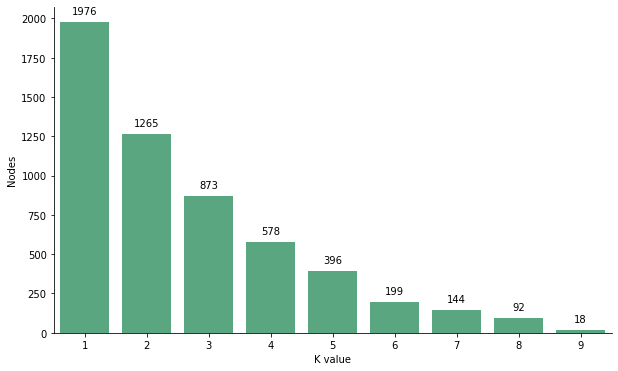

In [163]:
df = pd.DataFrame.from_dict(node_count_list, orient='index', columns=['value'])


fig, ax = plt.subplots(figsize=(10, 6))
sns.set_palette("Set2")

color = (0.3, 0.7, 0.5, 0.7)  # tuple with RGB values and alpha value
ax = sns.barplot(x=df.index, y='value', data=df, color=color)

for index, row in df.iterrows():
    ax.text(index-1, row['value']+50, row['value'], color='black', ha="center")

ax.set_xlabel("K value")
ax.set_ylabel("Nodes")

sns.despine()
plt.show()

In [266]:
# Nr of nodes part of a each k-shell. k values from 1 to 10
node_count_list = {}

for i in range(1, 10):   
    node_count = len(nx.k_shell(COMPLETE_WITH_SNOWB_EDGES, k=i).nodes)
    node_count_list[i] = node_count
    print(f'k={i}, {node_count}')

k=1, 711
k=2, 392
k=3, 295
k=4, 182
k=5, 197
k=6, 55
k=7, 52
k=8, 74
k=9, 18


In [321]:
K_CORES = nx.k_shell(COMPLETE_WITH_SNOWB_EDGES, k=7)

#for node in K_CORES.nodes():
    #print(glossary[node]['title'])
    #print(node)
    #COMPLETE_WITH_SNOWB_EDGES.nodes[node]["color"] = "red"
    #COMPLETE_WITH_SNOWB_EDGES.nodes[node]["style"] = "filled"

In [323]:
generate_graphviz_syntax(COMPLETE_WITH_SNOWB_EDGES)

In [306]:
for i in range(1,10):
    print(f'i = {i}, {len(list(nx.connected_components(nx.k_shell(COMPLETE_WITH_SNOWB_EDGES, k=i))))}')

i = 1, 708
i = 2, 286
i = 3, 125
i = 4, 66
i = 5, 33
i = 6, 27
i = 7, 7
i = 8, 1
i = 9, 1


In [310]:
generate_graphviz_syntax(nx.k_shell(COMPLETE_WITH_SNOWB_EDGES, k=8))